In [1]:
# define relevants paths and load functions and libraries

%run Bianchini2025_SC\\Analysis\\helper_functions\\functions_analysis.py
    
data_path = 'Bianchini2025_SC\\Datasets\\' # your data path
saving_path = 'Bianchini2025_SC\\Figures_output\\' # your saving figures path

In [3]:
# import relevant datasets

# load the main dataset
file= ''.join([data_path,'neurons_datasets\\delay_tuning_dataset.mat'])
data_dict = mat73.loadmat(file)
DAT=data_dict['merged_dataset']

# check keys available
print(DAT.keys())

# extract all keys
for k in DAT.keys():
    globals()[k] = DAT[k]

dict_keys(['AP_lim', 'ML_lim', 'all_boot_aud', 'all_boot_vis', 'animal_ID', 'binSize', 'coord3D', 'depth_lim', 'experiment_ID', 'modality', 'peaks', 'pvals', 'resp', 'spikes', 'trials', 'window_spikes'])


In [4]:
# Plot spatial distribution of absolute MII - Fig 1A

# first we need to calculate the MII
all_spikes_sub_mean, all_labels = shift_sum(spikes,trials,sub_mean=1)

# reshape it in a two dimensional array 
all_spikes_reshaped = all_spikes_sub_mean.reshape(all_spikes_sub_mean.shape[0],-1)
all_spikes_reshaped = all_spikes_reshaped.reshape(all_spikes_sub_mean.shape[0], -1, 50, all_spikes_sub_mean.shape[2])

# Compute the mean along the second axis
mean_array = np.mean(all_spikes_reshaped, axis=2)

spikes_smooth = mean_array

n_neurons = spikes_smooth.shape[0]
binSize = 0.01

its correct


In [5]:
# find the peaks of the response
peaks_all = np.zeros((n_neurons,spikes_smooth.shape[1])) # N x T

for n in range(n_neurons): # random order of trial for each neuron 
    
    this_neuron_spikes = spikes_smooth[n,:,2:]    
    
    # find the peakFR
    max_pos = np.argmax(this_neuron_spikes,axis=1) 
    
    for r in range(this_neuron_spikes.shape[0]):
        peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-1:max_pos[r]+2])/binSize
        
# now get the MII

MII_all = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
Adel_FR =[]
Asum_FR =[]
MII_all_old = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
for n in range(peaks_all.shape[0]):
    for d in range(11):
        del_FR = peaks_all[n,d]
        sum_FR = peaks_all[n,13+d]
        sum_FR_old = peaks_all[n,13-2]+peaks_all[n,13-1]

        if sum_FR <= 0 or del_FR <= 0:
            MII_all[n,d] = np.nan
            MII_all_old[n,d] = np.nan
        else:
            MII_all[n,d] = (del_FR - sum_FR)/sum_FR#(del_FR + sum_FR)#
            MII_all_old[n,d] = (del_FR - sum_FR_old)/sum_FR_old#(del_FR + sum_FR_old)
         
        Adel_FR.append(del_FR)
        Asum_FR.append(sum_FR)
        
print(np.nanmin(MII_all))
print(np.nanmax(MII_all))

-0.9500000000000001
1.5564440312192435e+17


In [13]:
# load the atlas SC images

dir1=file=''.join([data_path,'SC_AP_modified.tif'])
im_AP = imageio.imread(dir1)
img = Image.open(dir1)

dir2=file=''.join([data_path,'SC_ML_modified.tif'])
im_ML = imageio.imread(dir2)

im_AP=img.resize((im_AP.shape[0],im_ML.shape[0]))

#normalize values
ML_norm = ((coord3D[:,2] - ML_lim[0]) / (ML_lim[1] - ML_lim[0]))*im_ML.shape[1]
AP_norm = ((coord3D[:,0] - AP_lim[0]) / (AP_lim[1] - AP_lim[0]))*(673)+20
depth_norm = ((coord3D[:,1] -depth_lim[0]) / (depth_lim[1] - depth_lim[0]))*im_ML.shape[0]

ML_norm2 = ((coord3D[:,2] - ML_lim[0]) / (ML_lim[1] - ML_lim[0]))
AP_norm2 = ((coord3D[:,0] - AP_lim[0]) / (AP_lim[1] - AP_lim[0]))
depth_norm2 =  ((coord3D[:,1] -depth_lim[0]) / (depth_lim[1] - depth_lim[0]))

ML_norm3 = coord3D[:,2] - ML_lim[0]
AP_norm3 = coord3D[:,0] - AP_lim[0]
depth_norm3 = coord3D[:,1] - depth_lim[0]

coord3D_norm= np.transpose(np.array([ML_norm,AP_norm,depth_norm]))
coord3D_norm2= np.transpose(np.array([ML_norm2,AP_norm2,depth_norm2]))

# invert the ML axis first

max_val = im_ML.shape[1]
min_val = 0 
new_ML = np.array([max_val - val + min_val for val in ML_norm])
ML_norm = new_ML

max_val = 1
min_val = 0 
new_ML = np.array([max_val - val + min_val for val in ML_norm2])
ML_norm2 = new_ML

In [14]:
#%% let's calculate the gradient for all neurons at the preferred delay
good_pos2 = np.argwhere(~np.isnan(AP_norm))
extremes = np.array([0,(673)+20])
AP_corr = np.concatenate([np.squeeze(AP_norm[good_pos2]),extremes])

extremes = np.array([0,im_ML.shape[1]])
ML_corr = np.concatenate([np.squeeze(ML_norm[good_pos2]),extremes])

extremes = np.array([0,im_ML.shape[0]])
depth_corr = np.concatenate([np.squeeze(depth_norm[good_pos2]),extremes])

experiment_ID_corr = experiment_ID[good_pos2]
animal_ID_corr = animal_ID[good_pos2]

n_bins_tot=20
id_AP,edges_AP  = makeBins_SC(AP_corr,n_bins_tot)
id_ML,edges_ML = makeBins_SC(ML_corr,n_bins_tot)
id_depth,edges_depth = makeBins_SC(depth_corr,n_bins_tot)

id_AP = id_AP[:-2]
id_ML = id_ML[:-2]
id_depth = id_depth[:-2]

# after creating the bins create the combinations and give to each neuron the id of the bin it is in getBinIDs
var1,var2,var3 = id_ML,id_depth,id_AP
groups_ML,lengths,ID_neurons_ML,bins = getBinIDs(2,var1,var2,n_bins_tot)

groups_AP,lengths,ID_neurons_AP,bins = getBinIDs(2,var3,var2,n_bins_tot)

multi_peaks = peaks[:,:-2]  
pop_pref_delay = np.argmax(multi_peaks,axis=1)

max_MII = MII_all[np.arange(pop_pref_delay.shape[0]),pop_pref_delay]
absolute_MII = np.nanmean(abs(MII_all), axis=1)

these_MSI = absolute_MII[good_pos2]

these_IDs_ML = ID_neurons_ML
these_IDs_AP = ID_neurons_AP

mean_del_ML = np.zeros((groups_ML.shape[0],1))
mean_del_AP = np.zeros((groups_AP.shape[0],1))

for g in range(groups_AP.shape[0]):
    if these_MSI[these_IDs_ML==g].shape[0] > 0:
        mean_del_ML[g] = np.nanmean(these_MSI[these_IDs_ML==g])
    else:
        mean_del_ML[g] = np.nan
    if these_MSI[these_IDs_AP==g].shape[0] > 0:
        mean_del_AP[g] = np.nanmean(these_MSI[these_IDs_AP==g])
    else:
        mean_del_AP[g] = np.nan

# create the matrix to plot
mean_del_ML = np.swapaxes(mean_del_ML.reshape((n_bins_tot,n_bins_tot)),0,1)
mean_del_AP = np.swapaxes(mean_del_AP.reshape((n_bins_tot,n_bins_tot)),0,1)

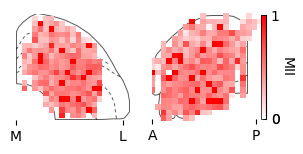

In [15]:
# Plot spatial distribution of absolute MII - Fig 1A
mean_del_ML[0,:] = np.nan
mean_del_AP[0,:] = np.nan

# get the limits
all_MSI_AP_ML = np.concatenate([mean_del_ML,mean_del_AP])
vmin = 0
vmax = 1
MSI_cmap = plt.cm.get_cmap('bwr')
MSI_cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])

dims = (1,2)
fig, axs = plt.subplots(*dims, figsize=(2.5,2), 
                        subplot_kw={'aspect': 1})
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# plot the ML SC
this_ax = axs[0]
this_ax.imshow(im_ML)
# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_aspect('equal')
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_xticklabels(['M', 'L'],fontsize=10)
this_ax.set_yticks([])

# overlay the binning
this_ax2 = fig.add_subplot(1,2,1)
im = this_ax2.imshow(mean_del_ML,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
this_ax2.patch.set_alpha(0.5)
this_ax2.set_position(this_ax.get_position())
this_ax2.axis('off')
this_ax2.set_aspect('equal')
this_ax2.set_xlim([0, n_bins_tot])
this_ax2.set_ylim([n_bins_tot, 0])

# plot the AP SC
this_ax = axs[1]
this_ax.imshow(im_AP)
# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_xticklabels(['A', 'P'],fontsize=10)
this_ax.set_yticks([])
this_ax.set_aspect('equal')

# overlay the binning
this_ax2 = fig.add_subplot(1,2,2)
im = this_ax2.imshow(mean_del_AP,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
this_ax2.patch.set_alpha(0.5)
this_ax2.set_position(this_ax.get_position())
this_ax2.set_aspect('equal')
this_ax2.set_xlim([0, n_bins_tot])
this_ax2.set_ylim([n_bins_tot, 0])
this_ax2.axis('off')

divider = make_axes_locatable(this_ax)
norm = LogNorm(vmin=vmin, vmax=vmax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax , norm=norm,ticks=[vmin, 0, vmax])
cbar.set_label('MII',rotation=-90,labelpad=10, fontsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
cbar.ax.spines['right'].set_visible(True)
cbar.ax.tick_params(width=0.5, length=2, direction='in', which='both', labelsize=10)
cbar.outline.set_linewidth(0.5)

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure5A.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

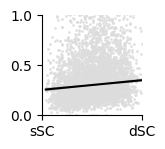

In [16]:
# Plot partial dependency plot for absolute MII - Fig 1B

fig,axs = plt.subplots(1,1,figsize=(1,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Exclude missing locations
good_pos = np.argwhere(~np.isnan(depth_norm))[:, 0]
# Extract and transpose the coordinates
features = np.swapaxes(np.vstack((ML_norm[good_pos], AP_norm[good_pos], depth_norm[good_pos])), 0, 1)

abs_MII = np.nanmean(abs(MII_all), axis=1)
target = abs_MII[good_pos]

# Exclude NaNs in target_old2 and align features
valid_indices = ~np.isnan(target)
target_filtered= target[valid_indices]

# Ensure that features2 and target2 are correctly aligned
features_filtered = features[valid_indices, :]

# Load the .mat file
file_dir = ''.join([data_path,'neurons_datasets\MII_prediction_results_DV_abs.mat'])
data = scipy.io.loadmat(file_dir, struct_as_record=False, squeeze_me=True)

# Access the variables
ypred3 = data['ypred']
yCI3 = data['yCI']
X3 = data['n_delay']

this_ax = axs
sns.regplot(x=features_filtered[:,2], y=target_filtered,scatter_kws={"color": 'gainsboro','s':1},fit_reg=False,ax = this_ax)
this_ax.plot(X3,ypred3,'k')
ciLower = yCI3[:, 0]
ciUpper = yCI3[:, 1]
this_ax.fill_between(X3, ciLower, ciUpper, color='k', alpha=0.2, edgecolor='none')
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_ylabel('')
this_ax.set_xlabel('')
this_ax.set_xlim([0,np.max(features_filtered[:,2])])
this_ax.set_xticks([0,np.max(features_filtered[:,2])] ,['sSC','dSC'])
this_ax.set_ylim([0,1])
this_ax.set_yticks([0,0.5,1])

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure5B.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


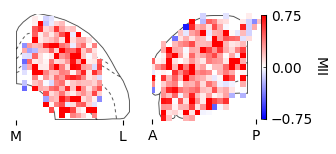

In [17]:
# Plot spatial distribution of max MII - Fig 1C

these_MSI = max_MII[good_pos2]

these_IDs_ML = ID_neurons_ML
these_IDs_AP = ID_neurons_AP

mean_del_ML = np.zeros((groups_ML.shape[0],1))
mean_del_AP = np.zeros((groups_AP.shape[0],1))

for g in range(groups_AP.shape[0]):
    if these_MSI[these_IDs_ML==g].shape[0] > 0:
        mean_del_ML[g] = np.nanmean(these_MSI[these_IDs_ML==g])
    else:
        mean_del_ML[g] = np.nan
    if these_MSI[these_IDs_AP==g].shape[0] > 0:
        mean_del_AP[g] = np.nanmean(these_MSI[these_IDs_AP==g])
    else:
        mean_del_AP[g] = np.nan

# create the matrix to plot
mean_del_ML = np.swapaxes(mean_del_ML.reshape((n_bins_tot,n_bins_tot)),0,1)
mean_del_AP = np.swapaxes(mean_del_AP.reshape((n_bins_tot,n_bins_tot)),0,1)

# there seem to be something weird
mean_del_ML[0,:] = np.nan
mean_del_AP[0,:] = np.nan

# get the limits
all_MSI_AP_ML = np.concatenate([mean_del_ML,mean_del_AP])
vmin = -0.75
vmax = 0.75
MSI_cmap = plt.cm.get_cmap('bwr')
#MSI_cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])

dims = (1,2)
fig, axs = plt.subplots(*dims, figsize=(2.5,2), 
                        subplot_kw={'aspect': 1})
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# plot the ML SC
this_ax = axs[0]
this_ax.imshow(im_ML)
# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_aspect('equal')
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_xticklabels(['M', 'L'],fontsize=10)
this_ax.set_yticks([])

# overlay the binning
this_ax2 = fig.add_subplot(1,2,1)
im = this_ax2.imshow(mean_del_ML,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
this_ax2.patch.set_alpha(0.5)
this_ax2.set_position(this_ax.get_position())
this_ax2.axis('off')
this_ax2.set_aspect('equal')
this_ax2.set_xlim([0, n_bins_tot])
this_ax2.set_ylim([n_bins_tot, 0])

# plot the AP SC
this_ax = axs[1]
this_ax.imshow(im_AP)
# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_xticklabels(['A', 'P'],fontsize=10)
this_ax.set_yticks([])
this_ax.set_aspect('equal')

# overlay the binning
this_ax2 = fig.add_subplot(1,2,2)
im = this_ax2.imshow(mean_del_AP,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
this_ax2.patch.set_alpha(0.5)
this_ax2.set_position(this_ax.get_position())
this_ax2.set_aspect('equal')
this_ax2.set_xlim([0, n_bins_tot])
this_ax2.set_ylim([n_bins_tot, 0])
this_ax2.axis('off')

divider = make_axes_locatable(this_ax)
norm = LogNorm(vmin=vmin, vmax=vmax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax , norm=norm,ticks=[vmin, 0, vmax])
cbar.set_label('MII',rotation=-90,labelpad=10, fontsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')
cbar.ax.spines['right'].set_visible(True)
cbar.ax.tick_params(width=0.5, length=2, direction='in', which='both', labelsize=10)
cbar.outline.set_linewidth(0.5)

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure5C.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

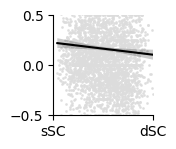

In [18]:
# Plot partial dependency plot for maximum MII - Fig 1B

fig,axs = plt.subplots(1,1,figsize=(1,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Exclude missing locations
good_pos = np.argwhere(~np.isnan(depth_norm))[:, 0]
# Extract and transpose the coordinates
features = np.swapaxes(np.vstack((ML_norm[good_pos], AP_norm[good_pos], depth_norm[good_pos])), 0, 1)

# Find the preferred delay for each neuron
multi_peaks = peaks[:, :-2]
pop_pref_delay = np.argmax(multi_peaks, axis=1)
max_MII = MII_all[np.arange(pop_pref_delay.shape[0]), pop_pref_delay]
target = max_MII[good_pos]

# Exclude NaNs in target_old2 and align features
valid_indices = ~np.isnan(target)
target_filtered= target[valid_indices]
features_filtered = features[valid_indices, :]

# Load the .mat file
file_dir = ''.join([data_path,'neurons_datasets\MII_prediction_results_DV.mat'])
data = scipy.io.loadmat(file_dir, struct_as_record=False, squeeze_me=True)

# Access the variables
ypred3 = data['ypred']
yCI3 = data['yCI']
X3 = data['n_delay']

this_ax = axs
sns.regplot(x=features_filtered[:,2], y=target_filtered,scatter_kws={"color": 'gainsboro','s':1},fit_reg=False,ax = this_ax)
this_ax.plot(X3,ypred3,'k')
ciLower = yCI3[:, 0]
ciUpper = yCI3[:, 1]
this_ax.fill_between(X3, ciLower, ciUpper, color='k', alpha=0.2, edgecolor='none')
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.set_ylabel('')
this_ax.set_xlabel('')
this_ax.set_xlim([0,np.max(features_filtered[:,2])])
this_ax.set_xticks([0,np.max(features_filtered[:,2])] ,['sSC','dSC'])
this_ax.set_ylim([-0.5,0.5])
this_ax.set_yticks([-0.5,0,0.5])

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure5D.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

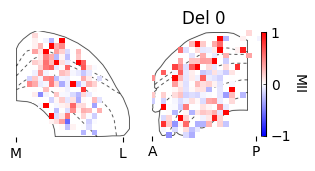

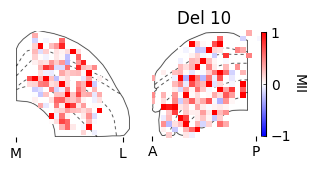

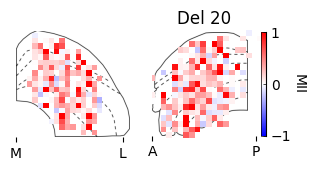

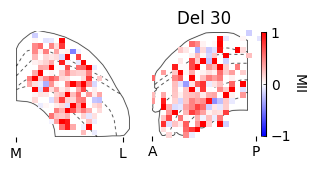

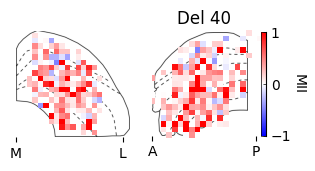

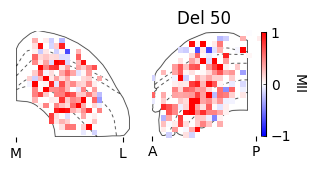

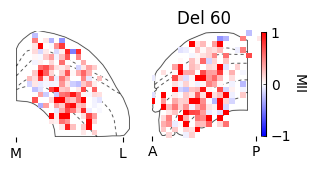

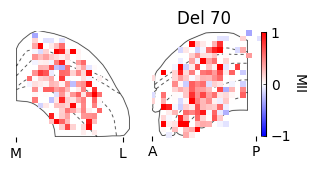

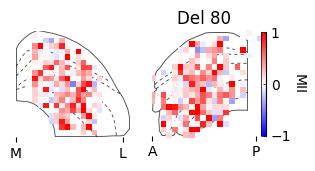

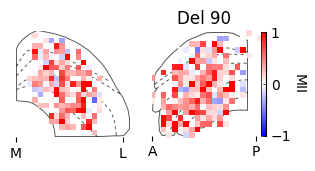

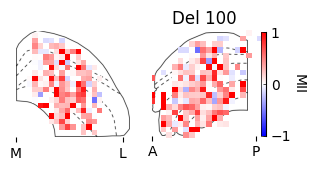

In [21]:
# plot MII maps for all delays

these_peaks = np.squeeze(peaks[good_pos2,:])
these_all_boot_vis = all_boot_vis[good_pos2,:]
these_all_boot_aud = all_boot_aud[good_pos2,:]

sig_del = []
which_tr = []
for i in range(these_peaks.shape[0]):
    y = these_peaks[i,:-2]

    vis_FR = these_peaks[i,-2]
    aud_FR = these_peaks[i,-1]

    if vis_FR>aud_FR:
        boot_out = these_all_boot_vis[i,:]
    elif aud_FR>vis_FR:
        boot_out = these_all_boot_aud[i,:]
    
    pos_sig = np.argwhere(boot_out>0).flatten()
    
    if len(pos_sig)>0:
        sig_del.append(i)
        tr = pos_sig[np.argmax(y[pos_sig])]
        which_tr.append(tr) 

sig_del = np.array(sig_del)
pref_delay=np.array(which_tr)

MII_subset = np.squeeze(MII_all[good_pos2,:])

these_IDs_ML = ID_neurons_ML[sig_del]
these_IDs_AP = ID_neurons_AP[sig_del]

for i in range(MII_subset.shape[1]):
    these_MSI = MII_subset[sig_del,i]
    
    mean_del_ML = np.zeros((groups_ML.shape[0],1))
    mean_del_AP = np.zeros((groups_AP.shape[0],1))

    for g in range(groups_AP.shape[0]):
        if these_MSI[these_IDs_ML==g].shape[0] > 0:
            mean_del_ML[g] = np.nanmean(these_MSI[these_IDs_ML==g])
        else:
            mean_del_ML[g] = np.nan
        if these_MSI[these_IDs_AP==g].shape[0] > 0:
            mean_del_AP[g] = np.nanmean(these_MSI[these_IDs_AP==g])
        else:
            mean_del_AP[g] = np.nan

    # create the matrix to plot
    mean_del_ML = np.swapaxes(mean_del_ML.reshape((n_bins_tot,n_bins_tot)),0,1)
    mean_del_AP = np.swapaxes(mean_del_AP.reshape((n_bins_tot,n_bins_tot)),0,1)

    # Plot spatial distribution of absolute MII - Fig 1A
    mean_del_ML[0,:] = np.nan
    mean_del_AP[0,:] = np.nan

    # get the limits
    all_MSI_AP_ML = np.concatenate([mean_del_ML,mean_del_AP])
    vmin = -1
    vmax = 1
    MSI_cmap = plt.cm.get_cmap('bwr')
    #MSI_cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])

    dims = (1,2)
    fig, axs = plt.subplots(*dims, figsize=(2.5,2), 
                            subplot_kw={'aspect': 1})
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # plot the ML SC
    this_ax = axs[0]
    this_ax.imshow(im_ML)
    # Remove the axis line
    this_ax.spines.left.set_visible(False)
    this_ax.spines.bottom.set_visible(False)
    this_ax.spines.right.set_visible(False)
    this_ax.spines.top.set_visible(False)
    this_ax.set_aspect('equal')
    this_ax.set_xticks([0, len(im_ML)])
    this_ax.set_xticklabels(['M', 'L'],fontsize=10)
    this_ax.set_yticks([])

    # overlay the binning
    this_ax2 = fig.add_subplot(1,2,1)
    im = this_ax2.imshow(mean_del_ML,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
    this_ax2.patch.set_alpha(0.5)
    this_ax2.set_position(this_ax.get_position())
    this_ax2.axis('off')
    this_ax2.set_aspect('equal')
    this_ax2.set_xlim([0, n_bins_tot])
    this_ax2.set_ylim([n_bins_tot, 0])

    # plot the AP SC
    this_ax = axs[1]
    this_ax.imshow(im_AP)
    # Remove the axis line
    this_ax.spines.left.set_visible(False)
    this_ax.spines.bottom.set_visible(False)
    this_ax.spines.right.set_visible(False)
    this_ax.spines.top.set_visible(False)
    this_ax.set_xticks([0, len(im_ML)])
    this_ax.set_xticklabels(['A', 'P'],fontsize=10)
    this_ax.set_yticks([])
    this_ax.set_aspect('equal')

    # overlay the binning
    this_ax2 = fig.add_subplot(1,2,2)
    im = this_ax2.imshow(mean_del_AP,aspect="equal",cmap=MSI_cmap,vmin=vmin, vmax=vmax)
    this_ax2.patch.set_alpha(0.5)
    this_ax2.set_position(this_ax.get_position())
    this_ax2.set_aspect('equal')
    this_ax2.set_xlim([0, n_bins_tot])
    this_ax2.set_ylim([n_bins_tot, 0])
    this_ax2.axis('off')

    divider = make_axes_locatable(this_ax)
    norm = LogNorm(vmin=vmin, vmax=vmax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax , norm=norm,ticks=[vmin, 0, vmax])
    cbar.set_label('MII',rotation=-90,labelpad=10, fontsize=10)
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.spines['right'].set_visible(True)
    cbar.ax.tick_params(width=0.5, length=2, direction='in', which='both', labelsize=10)
    cbar.outline.set_linewidth(0.5)

    this_ax.set_title(f'Del {i*10}')
    # define a saving directory and save it 
    dir = ''.join([saving_path,f'Supplementary_Figure5E_Del{i}.svg'])
    fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)